### Answers

> **1. Summary**

The (initial) exploration of data indicates that the likelihood (click rate) of a user viewing a link they receive has not changed over the three months. And to increase revenue the internet media company should send out more personalized daily digest emails between 9 AM and 11 AM, because users are most active during this 2 hour window.

> **2. Detailed Assessment**

- Calculated Link Click Rate defined as follows: 
$$\text{Click Rate}_{timeperiod} = \frac{\text{Number of Article Links Clicked}_{timeperiod}}{\text{Number of Articles Sent}_{timeperiod}}$$

- Montly Link Click Rate did not change over the 3 months as shown below:
    - January Link Click Rate = 0.165758
    - February Link Click Rate = 0.164100
    - March Link Click Rate = 0.164709
    
- Calculated Link Click Rate by Day. Then Performed a two-sided test for the null hypothesis that 2 independent samples (here I have assumed that the 2 samples are independent) have identical expected rate ($E[\text{Click Rate}]$), i.e. $E[\text{Click Rate}_{January}] = E[\text{Click Rate}_{March}]$
    - t-test statistic = 0.752735291122
    - p-value = 0.45620901575
    - $\text{p-value} > \alpha = 0.05$, thus this suggests that the two click rates (January click rate and March click rate) have identical expected rate. i.e. $E[\text{Click Rate}_{January}] = E[\text{Click Rate}_{March}]$
    - *The test suggests that the likelihood (or fraction or rate) of a user viewing a link they receive has not changed over the three months. However this result is based on aggregating rates of all users. A more micro level exploration will reveal the users that have an increased or decreased link viewing rate.*

> **3. Tools Used**

- Python (IPython Notebook), and some of the Python Packages I used are:
    - Numpy
    - Scipy
    - Pandas
    - Regular Expression
    - SQLAlchemy
    - Matplotlib
    - Seaborn
    - Datetime

> **4. Techniques Tried**

- Parsing *Apache Access Log* using Regular Expression
- Group By aggregations using SQLAlchemy and Pandas
- Fraction (rate) calculations
- Plotting data
- t-test for hypothesis testing

> **5. Three Plots that explain data**

- **Click Rate Vs Date** plot (below) shows that users link click rate has not changed during the months of January, February and March. It is very obvious from the plot that users are not clicking links during the weekends (Does this suggest that the internet media company is sending emails to users work email address?). [Click Rate Vs Date](#Click-Rate-Vs-Date)

- **Number of Articles Sent By Hour** plot (below) shows the sending out pattern of personalized daily digest emails by the internet media company. It can be observed that majority of daily digest emails are sent during first 4 hours of the work time (8 AM to Noon) with most emails sent at 8 AM. The afternoon email sending out activity is very low (Does this suggest that internet media company publishers/employees are not being productive?). [Number of Articles Sent By Hour](#Number-of-Articles-Sent-By-Hour)


- **Number of Article Links Clicked By Hour** plot (below) shows the link click pattern of users. It can be observed that users are most active (clicking links) between 9 AM and 11 AM. [Number of Article Links Clicked By Hour](#Number-of-Article-Links-Clicked-By-Hour)


> **6. Commercial Recommendation for Business Unit Heads**

The internet media company should send out more personalized daily digest emails between 9 AM and 11 AM, because users are most active during this 2 hour window (One possible reason would be users are taking a break from work). This action has potential to increase revenue.

> **7. Additional Data and Questions that additional data can help answer**

- Data on "How much time does a user spend on links by topic and type?"
    - Difficult to get because some users may leave the link open for a long time (this can cause outlier problems)
    - This data can help in improving recommendations of right content to send to users
    
- Data on "When and on which topics/types changes (and other changes) that are being made by the company?"
    - This data can help one to understand user behavior to changes so that improvements to recommendations of right content to send to users can be made.
    
- I have just barely scratched the surface of current given data. Using this data one can find out what topic/type links a user clicks on (i.e. a user is interested in). Based on this information of user interests and other relevant features, a user similarity score (euclidean or manhattan or cosine distances) can be calculated. Eventually this user similarity score can be used for developing a recommendation system.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy as sp
from sqlalchemy import create_engine
import sqlite3

import re
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator
import seaborn as sns
#sns.set_style("whitegrid")
sns.set_context("poster")

## Parsing Apache Access Log

- Contains user clickstreams: for each click on an article link by a user, there is a row in the log file
- File format
```python
[%t]"GET /click?article_id= %d1 &user_id=%d2 HTTP/1.0"%b%d3
```
- %t = time (EST)
- %d1 = article id
- %d2 = user id
- %b = status code that the server sends the client
- %d = byte size of the content returned by server

Example of a log line:
```
[01/Apr/2015:15:25:51] "GET /click?article_id=16973&user_id=15876 HTTP/1.1" 200 2495 
```

[Apache Access Log](https://httpd.apache.org/docs/2.2/logs.html#accesslog)

In [2]:
# Test to extract log data using regular expression (http://pythex.org/)
log_pattern = '^\[([\w:/]+)\] "(\S*) (\S*) (\S*)" (\d{3}) (\S+)' 

s = '[01/Apr/2015:15:25:51] "GET /click?article_id=16973&user_id=15876 HTTP/1.1" 200 2495'
m = re.search(log_pattern, s)
print 'Match: ', m.groups()
print 'Article User String: ', m.group(3)
print 'Article Id: ', re.findall(r'\d+', m.group(3))[0]
print 'User Id: ', re.findall(r'\d+', m.group(3))[1]

Match:  ('01/Apr/2015:15:25:51', 'GET', '/click?article_id=16973&user_id=15876', 'HTTP/1.1', '200', '2495')
Article User String:  /click?article_id=16973&user_id=15876
Article Id:  16973
User Id:  15876


In [3]:
# Apache time format: [day/month/year:hour:minute:second] 

# Month map
month_map = {'Jan': 1, 'Feb': 2, 'Mar':3, 'Apr':4, 'May':5, 'Jun':6, 'Jul':7, 'Aug':8,  'Sep': 9, 'Oct':10, 'Nov': 11, 'Dec': 12}

# Function to convert Apache time format to Python datetime object
def parse_apache_time(str_):
    '''
    Args: 
        str_ : date and time in apache time format
    Returns: 
        datetime: python datetime object ('%Y-%m-%d %H:%M:%S.%f')
    '''
    Y = int(str_[7:11])
    M = int(month_map[str_[3:6]])
    D = int(str_[0:2])
    h = int(str_[12:14])
    m = int(str_[15:17])
    s = int(str_[18:20])
    return datetime.datetime(Y, M, D, h, m, s)
    
print parse_apache_time('01/Apr/2015:15:25:51')

2015-04-01 15:25:51


In [4]:
log_pattern = '^\[([\w:/]+)\] "(\S*) (\S*) (\S*)" (\d{3}) (\S+)' 

def parse_apache_log_line(log_pattern, log_line):
    '''
    Args:
        log_line (str): a line of text in the apache log format
        log_pattern: a regular expression pattern
    Returns:
        tuple of date time, article id, user id, status code, byte size
    '''
    match = re.search(log_pattern, log_line)
    date_time = parse_apache_time(match.group(1))
    article_user_str = match.group(3)
    # Extract: article id and user id from article_user_str
    temp = re.findall(r'\d+', article_user_str)
    article_id = int(temp[0])
    user_id = int(temp[1])
    status_code = int(match.group(5))
    byte_size = int(match.group(6))
    return (date_time, article_id, user_id, status_code, byte_size)

print 'Test: ', parse_apache_log_line(log_pattern, s)

Test:  (datetime.datetime(2015, 4, 1, 15, 25, 51), 16973, 15876, 200, 2495)


In [5]:
# Read access.log and save as *.csv
with open("data/access.log", "r") as in_:
    out_ = []
    for line in in_:
        out_.append(parse_apache_log_line(log_pattern, line))
        
df = pd.DataFrame(out_, columns = ['date_time', 'article_id', 'user_id', 'status_code', 'byte_size'])

# Uncomment the line below to save as csv
#df.to_csv("data/accessLog.csv", index = False)
df.head(3)

,date_time,article_id,user_id,status_code,byte_size
0,2015-01-02 08:07:32,162,5475,200,4352
1,2015-01-02 08:08:43,139,19550,200,3078
2,2015-01-02 08:09:01,87,9408,200,2005


In [6]:
print df['status_code'].unique()

[200 400]


There are 2 status codes in the clickstream log data:
- 200: OK, i.e. the request was received and understood and is being processed
- 400: Bad Request, i.e. the server did not understand the request due to bad syntax.

In [7]:
print df.groupby('status_code').count()

             date_time  article_id  user_id  byte_size
status_code                                           
200            1762015     1762015  1762015    1762015
400               8766        8766     8766       8766


<font color=red>Number of Bad Requests: 8766</font>

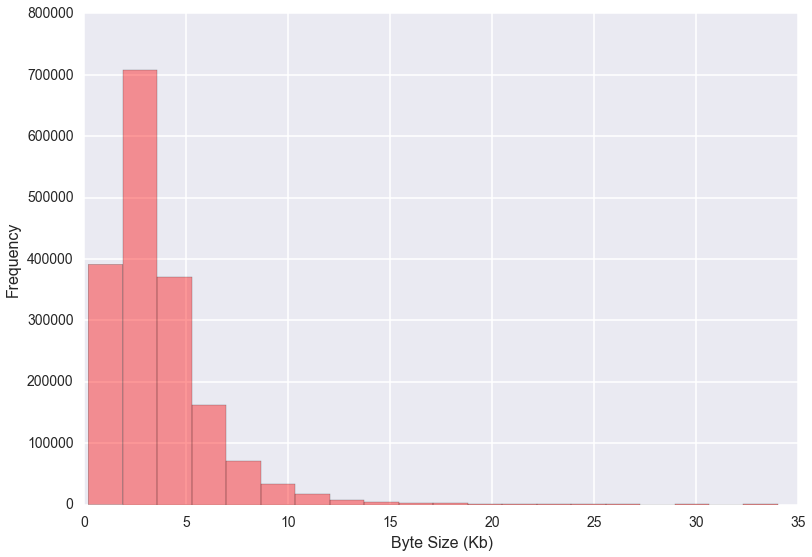

In [8]:
# Histogram of byte size
sns.distplot(df['byte_size']/1000.0, bins = 20, kde = False, rug = False, color = 'r')
plt.xlabel('Byte Size (Kb)', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

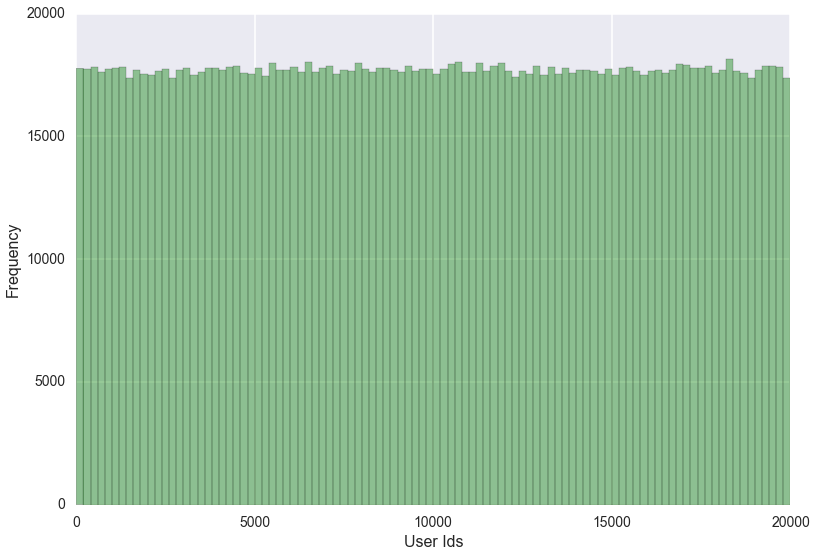

In [9]:
# Histogram of user id
sns.distplot(df['user_id'], bins = 100, kde = False, rug = False, color = 'g')
plt.xlabel('User Ids', fontsize = 16)
plt.ylabel('Frequency', fontsize = 16)
plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

In [10]:
# Delete 'status_code' and 'byte_size' for the current analysis
del df['status_code']
del df['byte_size']
df.head(3)

,date_time,article_id,user_id
0,2015-01-02 08:07:32,162,5475
1,2015-01-02 08:08:43,139,19550
2,2015-01-02 08:09:01,87,9408


In [11]:
print df['date_time'].min()
print df['date_time'].max()

2015-01-02 08:07:32
2015-04-01 15:25:51


## SQLite DB

- **users**
- **topics**
- **types**
- **articles**
- **email_content**

In [12]:
# Initialie database
db = create_engine('sqlite:///data/contentDiscovery.db')

#### Populating SQLite DB with Pandas

In [ ]:
df.to_sql("logs", db, if_exists = "append", index = False)

In [13]:
# users table
users_df = pd.read_sql_query('SELECT * FROM users', db)
print 'Number of users: ', users_df.shape[0]
users_df.tail(3)

Number of users:  20000


,user_id,email
19997,19998,james.rush@xmssl.com
19998,19999,charles.lee@cxnqx.com
19999,20000,arthur.alexander@zgtec.com


In [14]:
# topics table
topics_df = pd.read_sql_query('SELECT * FROM topics', db)
print 'Number of topics: ', topics_df.shape[0]
topics_df.head(3)

Number of topics:  106


,topic_id,name
0,1,Advertising
1,2,Auditing
2,3,Banks


In [15]:
# types table
types_df = pd.read_sql_query('SELECT * FROM types', db)
print 'Number of types: ', types_df.shape[0]
types_df.tail(3)

Number of types:  49


,type_id,name
46,47,Video
47,48,Webinar
48,49,White paper


In [16]:
# articles table
articles_df = pd.read_sql_query('SELECT * FROM articles', db)
print 'Number of articles: ', articles_df.shape[0]
articles_df.tail(3)

Number of articles:  17029


,article_id,author_id,topic_id,type_id,submission_time
17026,17027,15226,90,38,2015-03-31 21:53:15.405462
17027,17028,15497,77,1,2015-03-31 22:30:17.132310
17028,17029,4057,96,47,2015-03-31 22:39:51.649115


In [17]:
# email content table - takes time use limit to check the contents
email_df = pd.read_sql_query('SELECT * FROM email_content LIMIT 10', db)
email_df.head(3)

,content_id,email_id,user_id,article_id,send_time
0,1,1,11460,66,2015-01-02 08:06:20.070850
1,2,1,11460,135,2015-01-02 08:06:20.070850
2,3,1,11460,175,2015-01-02 08:06:20.070850


In [18]:
# log table - takes time use limit to check the contents
log_df = pd.read_sql_query('SELECT * FROM logs LIMIT 10', db)
log_df.head(3)

,date_time,article_id,user_id
0,2015-01-02 08:07:32.000000,162,5475
1,2015-01-02 08:08:43.000000,139,19550
2,2015-01-02 08:09:01.000000,87,9408


In [ ]:
len(pd.read_sql_query('SELECT DISTINCT article_id FROM logs', db))

In [ ]:
len(pd.read_sql_query('SELECT DISTINCT article_id FROM email_content', db))

In [ ]:
len(pd.read_sql_query('SELECT DISTINCT content_id FROM email_content', db))

In [ ]:
len(pd.read_sql_query('SELECT DISTINCT email_id FROM email_content', db))

- Number of unique article_id in logs table: 25683
- Number of unique article_id in email_content table: 16982
- Number of unique content_id in email_content table: 10738006
- Number of unique email_id in email_content table: 1058436

In [19]:
# SQLite date: https://www.sqlite.org/lang_datefunc.html
pd.read_sql_query('SELECT DATE(send_time) as date FROM email_content LIMIT 3', db)

,date
0,2015-01-02
1,2015-01-02
2,2015-01-02


## Sent and Click Count

In [20]:
sent_df = pd.read_sql_query('SELECT user_id, DATE(send_time) AS date, COUNT(article_id) as send_count \
                                FROM email_content GROUP BY user_id, date', db)
sent_df.head(3)

,user_id,date,send_count
0,1,2015-01-02,9
1,1,2015-01-05,9
2,1,2015-01-07,12


In [21]:
print sent_df.shape
print len(sent_df['date'].unique())

(1058436, 3)
63


In [22]:
click_df = pd.read_sql_query('SELECT user_id, DATE(date_time) AS date, COUNT(article_id) as click_count \
                                FROM logs GROUP BY user_id, date', db)
click_df.head(3)

,user_id,date,click_count
0,1,2015-01-02,1
1,1,2015-01-05,2
2,1,2015-01-07,1


In [23]:
print click_df.shape
print len(click_df['date'].unique())

(858625, 3)
78


In [24]:
print type(sent_df['date'][0])
print type(click_df['date'][0])

<type 'unicode'>
<type 'unicode'>


In [25]:
# Clicked next day
# 6451 did not match - because did not click the same day as send date
a = sent_df['date'].unique()
b = click_df['date'].unique()
[i for i in b if i not in a]

[u'2015-01-31',
 u'2015-01-03',
 u'2015-01-24',
 u'2015-01-17',
 u'2015-02-28',
 u'2015-04-01',
 u'2015-01-10',
 u'2015-02-21',
 u'2015-03-21',
 u'2015-02-14',
 u'2015-01-18',
 u'2015-02-07',
 u'2015-03-28',
 u'2015-03-14',
 u'2015-03-07']

In [26]:
# Same day clicks
sent_click_df = pd.merge(sent_df, click_df, how = 'left', left_on = ['user_id', 'date'], 
                        right_on = ['user_id', 'date'])
sent_click_df.head(3)

,user_id,date,send_count,click_count
0,1,2015-01-02,9,1
1,1,2015-01-05,9,2
2,1,2015-01-07,12,1


In [27]:
d = pd.date_range(start = '2015-01-01', end = '2015-04-01')
dates = pd.DataFrame({'date': d})
dates.head(3)

,date
0,2015-01-01
1,2015-01-02
2,2015-01-03


In [28]:
print type(dates['date'][0])

<class 'pandas.tslib.Timestamp'>


In [29]:
clicks = sent_click_df[['date', 'send_count', 'click_count']].groupby('date').sum().reset_index()
clicks['rate'] = clicks['click_count']/(clicks['send_count'])
clicks['date'] = clicks['date'].map(lambda t: pd.to_datetime(t))
clicks.head(3)

,date,send_count,click_count,rate
0,2015-01-02,209160,35356,0.169038
1,2015-01-05,187213,29789,0.159118
2,2015-01-06,168548,28018,0.166232


In [30]:
click_rate = pd.merge(dates, clicks, how = 'left', on = 'date')
click_rate['rate'].fillna(0, inplace = True)
click_rate.head(3)

,date,send_count,click_count,rate
0,2015-01-01,NaN,NaN,0.000000
1,2015-01-02,209160,35356,0.169038
2,2015-01-03,NaN,NaN,0.000000


In [31]:
type(click_rate['date'][0])

pandas.tslib.Timestamp

In [32]:
click_rate['date'] = click_rate['date'].apply(lambda t: datetime.date(t.year,t.month,t.day))

In [33]:
type(click_rate['date'][0])

datetime.date

In [34]:
print click_rate['date'].min()
click_rate['date'].max()

2015-01-01


datetime.date(2015, 4, 1)

#### Click Rate Vs Date

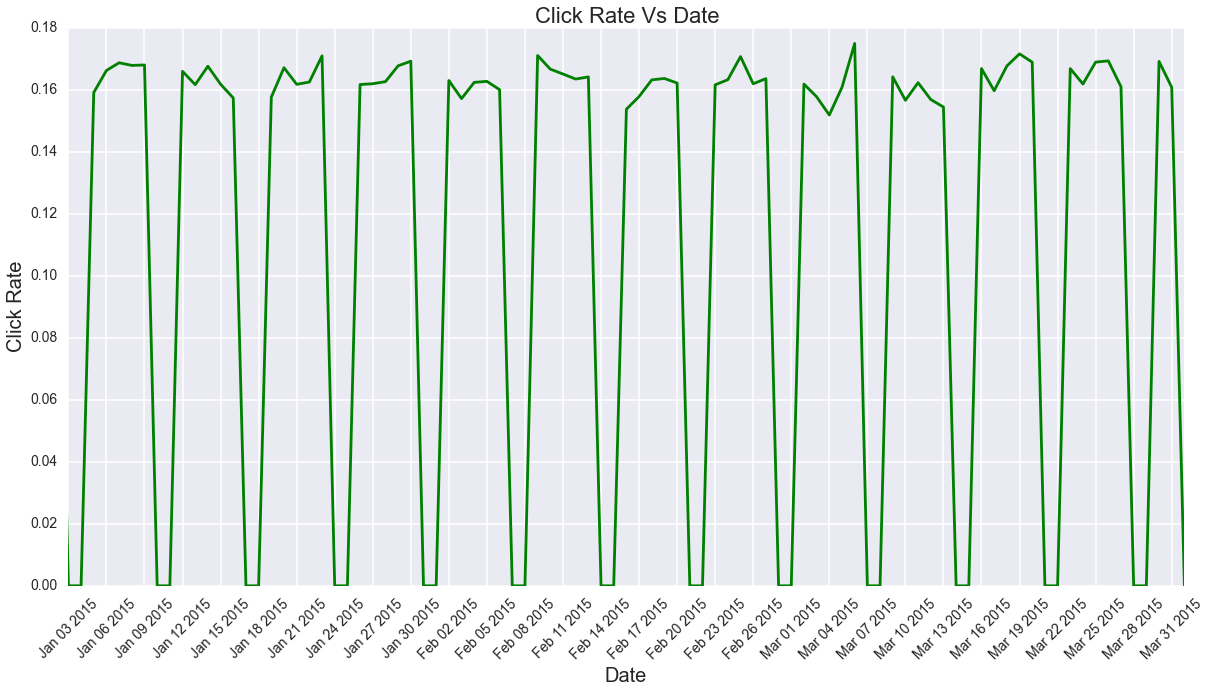

In [35]:
# Click Rate Vs Date
from matplotlib.dates import DayLocator

fig, ax = plt.subplots(1, 1,figsize=(20, 10))
plt.plot(click_rate['date'], click_rate['rate'], color = 'g')
plt.xlabel('Date', fontsize = 20)
plt.ylabel('Click Rate', fontsize = 20)
plt.title('Click Rate Vs Date', fontsize = 22)

# X axis time settings
plt.xticks(rotation = 45)
plt.xlim(datetime.date(2015, 1, 3), datetime.date(2015, 4, 1))
ax.xaxis.set_major_locator(DayLocator(bymonthday = range(1,32), interval = 3))

plt.tick_params(axis = 'both', which = 'major', labelsize = 14)

## Monthly Click Rate

In [36]:
sent_month = pd.read_sql_query('SELECT user_id, STRFTIME("%m", send_time) AS month, COUNT(article_id) as send_count \
                                FROM email_content GROUP BY user_id, month', db)
sent_month.head(3)

,user_id,month,send_count
0,1,01,148
1,1,02,174
2,1,03,192


In [37]:
click_month = pd.read_sql_query('SELECT user_id, STRFTIME("%m", date_time) AS month, COUNT(article_id) as click_count \
                                FROM logs GROUP BY user_id, month', db)
click_month.head(3)

,user_id,month,click_count
0,1,01,21
1,1,02,22
2,1,03,30


In [38]:
sent_click_month = pd.merge(sent_month, click_month, how = 'left', left_on = ['user_id', 'month'], 
                        right_on = ['user_id', 'month'])
sent_click_month.head(3)

,user_id,month,send_count,click_count
0,1,01,148,21
1,1,02,174,22
2,1,03,192,30


In [39]:
month_click_rate = sent_click_month[['month', 'send_count', 'click_count']].groupby('month').sum().reset_index()
month_click_rate['rate'] = month_click_rate['click_count']/month_click_rate['send_count']
month_click_rate.head(3)

,month,send_count,click_count,rate
0,01,3618751,599838,0.165758
1,02,3388585,556067,0.164100
2,03,3730670,614476,0.164709


### Daily Click Rate - Reduntant calculation

In [40]:
sent_month_day = pd.read_sql_query('SELECT STRFTIME("%m", send_time) AS month, STRFTIME("%d", send_time) AS day, COUNT(article_id) as send_count \
                                FROM email_content GROUP BY month, day', db)
sent_month_day.head(3)

,month,day,send_count
0,01,02,209160
1,01,05,187213
2,01,06,168548


In [41]:
click_month_day = pd.read_sql_query('SELECT STRFTIME("%m", date_time) AS month, STRFTIME("%d", date_time) AS day, COUNT(article_id) as click_count \
                                FROM logs GROUP BY month, day', db)
click_month_day.head(3)

,month,day,click_count
0,01,02,35356
1,01,03,482
2,01,05,29789


In [42]:
sent_click_day = pd.merge(sent_month_day, click_month_day, how = 'left', \
                         on = ['month', 'day'])
sent_click_day['rate'] = sent_click_day['click_count']/sent_click_day['send_count']
sent_click_day.head(3)

,month,day,send_count,click_count,rate
0,01,02,209160,35356,0.169038
1,01,05,187213,29789,0.159118
2,01,06,168548,28142,0.166967


In [43]:
day_click_rate = sent_click_day[['month', 'day', 'rate']].groupby(['month', 'day']).sum().reset_index()
jan_rate = day_click_rate[day_click_rate['month'] == '01']
mar_rate = day_click_rate[day_click_rate['month'] == '03']

#### t-Test Comparing January click rates to March click rates

Two-sided test for the null hypothesis that 2 independent samples (here I have assumed that the 2 samples are independent) have identical expected rate ($E[rate]$)

In [44]:
t_test = sp.stats.ttest_ind(jan_rate['rate'], mar_rate['rate'], axis = 0, equal_var = False)
print 't-Statistic: ', t_test[0]
print 'p-value: ', t_test[1]

t-Statistic:  0.752735291122
p-value:  0.45620901575


$\text{p-value} > \alpha = 0.05$, thus this suggests that the two rates (January rate and March rate) have identical expected rate. 
$$E[rate_{January}] = E[rate_{March}]$$

**The test suggests that the likelihood (or fraction or rate) of a user viewing a link they receive has not changed over the three months. However this result is based on aggregating rates of all users. A more micro level exploration will reveal the users that have an increased or decreased link viewing rate.**

## Month and Hour (Sent and Click Plots)

In [45]:
sent_hour_df = pd.read_sql_query('SELECT STRFTIME("%m", send_time) AS month, STRFTIME("%H", send_time) as hour, COUNT(article_id) as send_count \
                                FROM email_content GROUP BY month, hour', db)
sent_hour_df.head(3)

,month,hour,send_count
0,01,08,1086699
1,01,09,847207
2,01,10,498413


In [46]:
sent_hour_counts = sent_hour_df.pivot(index = 'hour', columns = 'month', values = 'send_count')
sent_hour_counts.columns = ['January', 'February', 'March']

#### Number of Articles Sent By Hour

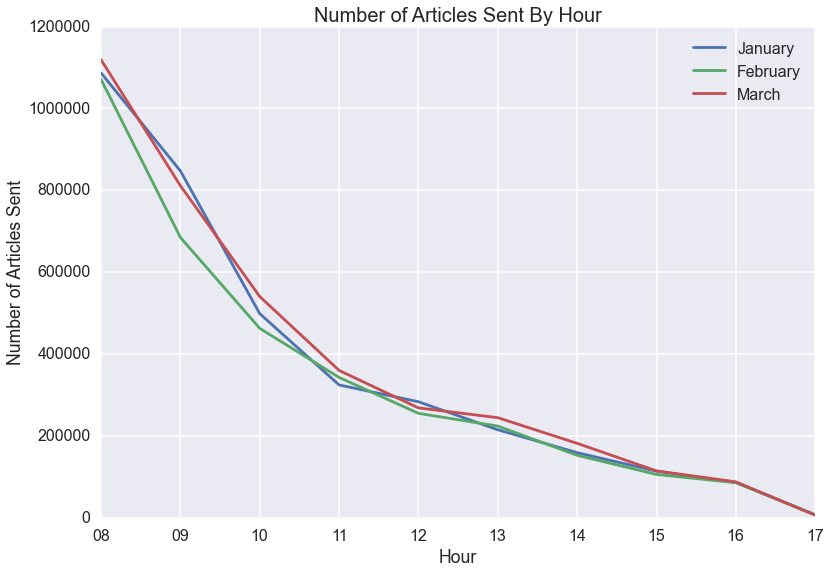

In [47]:
sent_hour_counts.plot()
plt.ylabel('Number of Articles Sent')
plt.xlabel('Hour')
plt.title('Number of Articles Sent By Hour', fontsize = 20)

In [48]:
click_hour_df = pd.read_sql_query('SELECT STRFTIME("%m", date_time) AS month, STRFTIME("%H", date_time) AS hour, COUNT(article_id) as click_count \
                                FROM logs GROUP BY month, hour', db)
click_hour_df.head(3)

,month,hour,click_count
0,01,00,2647
1,01,01,1892
2,01,02,1414


In [49]:
click_hour_counts = click_hour_df.pivot(index = 'hour', columns = 'month', values = 'click_count')
del click_hour_counts['04']
click_hour_counts.columns = ['January', 'February', 'March']

#### Number of Article Links Clicked By Hour

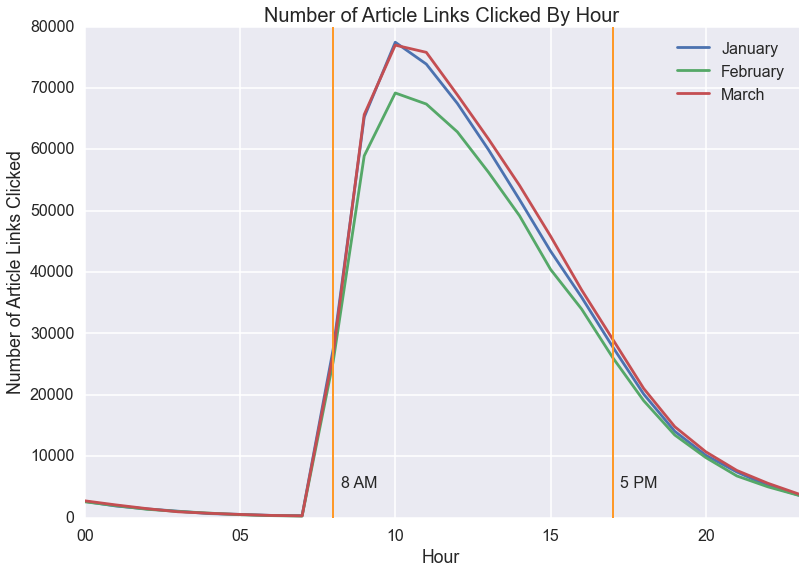

In [50]:
click_hour_counts.plot()
plt.ylabel('Number of Article Links Clicked')
plt.xlabel('Hour')
plt.axvline(x = 8, color = '#fe9929', linewidth = 2)
plt.text(8.25, 5000, '8 AM', fontsize = 16)
plt.axvline(x = 17, color = '#fe9929', linewidth = 2)
plt.text(17.25, 5000, '5 PM', fontsize = 16)
plt.title('Number of Article Links Clicked By Hour', fontsize = 20)

> ## Testing Analysis Ideas (in the cells below)

```python
sent_click = pd.read_sql_query('''SELECT send.user_id AS user_id,
           send.date AS send_date,
           click.date AS click_date,
           send.count AS send_count,
           click.count AS click_count
      FROM (
            SELECT user_id, DATE(send_time) AS date,
                   COUNT(article_id) AS count
              FROM email_content
             GROUP BY user_id, date
           ) send
      
      LEFT JOIN (
            SELECT user_id, DATE(date_time) AS date,
                   COUNT(article_id) AS count
              FROM logs
             GROUP BY user_id, date
           ) click
        ON send.user_id = click.user_id
        AND send.send_date = click.click_date''', db)
        ```

### Testing with user_id between 1 and 11

In [ ]:
temp_email = pd.read_sql_query('SELECT user_id, article_id, DATE(send_time) \
                                AS date FROM email_content WHERE user_id = 1', db)
temp_email.head(3)

In [ ]:
a = temp_email.groupby(['user_id', 'date']).count().reset_index()

In [ ]:
temp_log = pd.read_sql_query('SELECT user_id, article_id, DATE(date_time) \
                                AS date FROM logs WHERE user_id = 1', db)
temp_log.head(3)

In [ ]:
b = temp_log.groupby(['user_id', 'date']).count().reset_index()

In [ ]:
pd.merge(a, b, how = 'left', on = ['user_id', 'date'])

In [ ]:
temp_email = pd.read_sql_query('SELECT * FROM email_content WHERE user_id \
                                BETWEEN 1 AND 11', db)

temp_log = pd.read_sql_query('SELECT * FROM logs WHERE user_id \
                                BETWEEN 1 AND 11', db)

In [ ]:
temp_email.head(3)

In [ ]:
temp_email[temp_email['email_id'] == 3309].head(3)

In [ ]:
#re.findall(r'\d{4}-\d{2}-\d{2}', temp_email['send_time'][0])[0]
#re.search(r'\d{4}-\d{2}-\d{2}', temp_email['send_time'][0]).group(0)

In [ ]:
temp_email['send_time'] = temp_email['send_time'].map(lambda t: pd.to_datetime(t))
type(temp_email['send_time'][0])

In [ ]:
temp_log.head(3)

In [ ]:
temp_log[temp_log['user_id'] == 1]

In [ ]:
temp = pd.merge(temp_email, temp_log, on = ['user_id', 'article_id'])
temp = pd.merge(temp, articles_df, on = 'article_id', suffixes = ('_left', '_right'))
temp.head(3)

In [ ]:
del temp['content_id']
del temp['email_id']
del temp['author_id']
del temp['submission_time']
temp.head(3)

In [ ]:
print pd.to_datetime(temp['send_time'][0])
print pd.to_datetime(temp['date_time'][0])

In [ ]:
temp['date_time'] = temp['date_time'].map(lambda t: pd.to_datetime(t))
temp['send_time'] = temp['send_time'].map(lambda t: pd.to_datetime(t))

In [ ]:
temp['time_diff'] = temp['date_time'] - temp['send_time']

In [ ]:
temp['time_diff'][0]/np.timedelta64(1, 's')

In [ ]:
temp.head(3)

In [ ]:
print type(temp['send_time'][0])
print type(temp['date_time'][0])
print temp['date_time'][0].second

In [ ]:
len(temp['date_time'].map(lambda t: int(str(t.month)+str(t.day))).unique())

In [ ]:
temp['date_time'].map(lambda t: t.month).unique()